## This notebook will cover making an example algorithm with out training data

Guides / other resources:

- [Kaggle asset trading guide](https://www.kaggle.com/code/shtrausslearning/building-an-asset-trading-strategy)
- [Kaggle simple momentum trader](https://www.kaggle.com/code/amirmotefaker/algorithmic-trading)
- [Kaggle Decision Trees for trading](https://www.kaggle.com/code/sndorburian/decision-tree-for-trading-using-python)

Less Relevant:
- [Kaggle Features Hierarchical clustering](https://www.kaggle.com/code/apolitano20/jane-street-features-hierarchical-clustering/notebook)
- [Optiver intro to financial concepts](https://www.kaggle.com/code/jiashenliu/introduction-to-financial-concepts-and-data)
    - kaggle notebook covering their volatility prediction competition


### Creating an Algorithm

In general there are a general steps to creating a trading algorithm:
1. Understanding and Exploring your data
    - get to know what data you're given and finding various statistical or other properties about it
2. Feature/signal creation
    - create signals from the data be that statistical like rolling average or correlation etc (this is where most of your secret sauce is going to be)
3. Feature selection + model creation
    - Decide what features to include in your model that will then decide to buy/sell/hold etc
    - this also involves if you will make a machine learning type model or a rules-based model
4. Testing
    - Lastly we need to test our model to see how it performed. It is crucial that you don't have "data leakage" - that you trade on a day given future information this will ruin your model results when it comes to scoring your model

iterate steps 2-4 to refine and come up with a better model!

### Different types of models
- ML type (supervised vs unsupervised)
- Decision Trees (rule-based ML approach)
    - XGBoost
- rule-based (hand coded or other)


## Algorithms Input and Output
The algorithms will take in data in a similar form to `train_data.csv`. 

The output of the model should be a Numpy array of size SxD where S = number of stocks (in alphabetical order ascending), and D = the number of days. 
For example if we had stock A and B and had 5 days of trading we could output something like below:
```python
[[0,3,0,-1,-5], # trades for stock A
 [1,5,0,-6, 3]] # trades for stock B
```

Trades that have a positive value mean that we bought shares, and negative values mean that we sold shares or shorted shares (short in the case that we don't own the underlying shares).

In order to output this numpy array once you have generated it you can do something like 
```python
import numpy as np

output = np.array([[...],
                   [...],
                    ... ])

# Save the array to a .npy file
np.save('output.npy', output)
```

### Exploring the Data
We went though this in the [reading_data.ipynb](reading_data.ipynb) notebook

## Example Simple SMA Algorithm
In this example I will make a simple moving average algorithm and trade it on all the stock.

[What is SMA?](https://www.investopedia.com/terms/s/sma.asp#:~:text=A%20simple%20moving%20average%20(SMA)%20is%20an%20arithmetic%20moving%20average,periods%20in%20the%20calculation%20average.)


You can download the train data here [Google Drive Link](https://drive.google.com/file/d/1ruCDFeUqLEkPDfSLBqDMf8swyU1ECEwq/view?usp=sharing)

In [1]:
## Loading the Data
import pandas as pd

# Read the training and testing data from CSV files
train_df = pd.read_csv('train_data_50.csv') # TODO: make sure that the train_data.csv file is in the same directory as this!

# change date into datetime objects
train_df['Date'] = pd.to_datetime(train_df['Date'])

# set indexes 
train_df.set_index(["Ticker", "Date"], inplace=True)

print(train_df)

                        Open       High        Low      Close  Adj Close  \
Ticker Date                                                                
ZV     2015-07-06  12.884924  13.017960  12.875642  12.994240  11.741812   
       2015-07-07  12.982896  13.009710  12.764262  12.962270  11.712925   
       2015-07-08  12.837485  12.853985  12.637414  12.640508  11.422177   
       2015-07-09  12.772513  12.794170  12.295026  12.382686  11.189203   
       2015-07-10  12.575537  12.772513  12.500253  12.713729  11.488340   
...                      ...        ...        ...        ...        ...   
ZF     2021-04-05  23.637141  23.645392  23.158623  23.307129  20.958649   
       2021-04-06  23.447384  23.736146  23.208125  23.241127  20.899297   
       2021-04-07  23.261752  23.418508  23.199876  23.344255  20.992038   
       2021-04-08  23.071995  23.133873  22.820361  23.100871  20.773174   
       2021-04-09  23.100871  23.282378  22.906988  23.047244  20.724952   

           

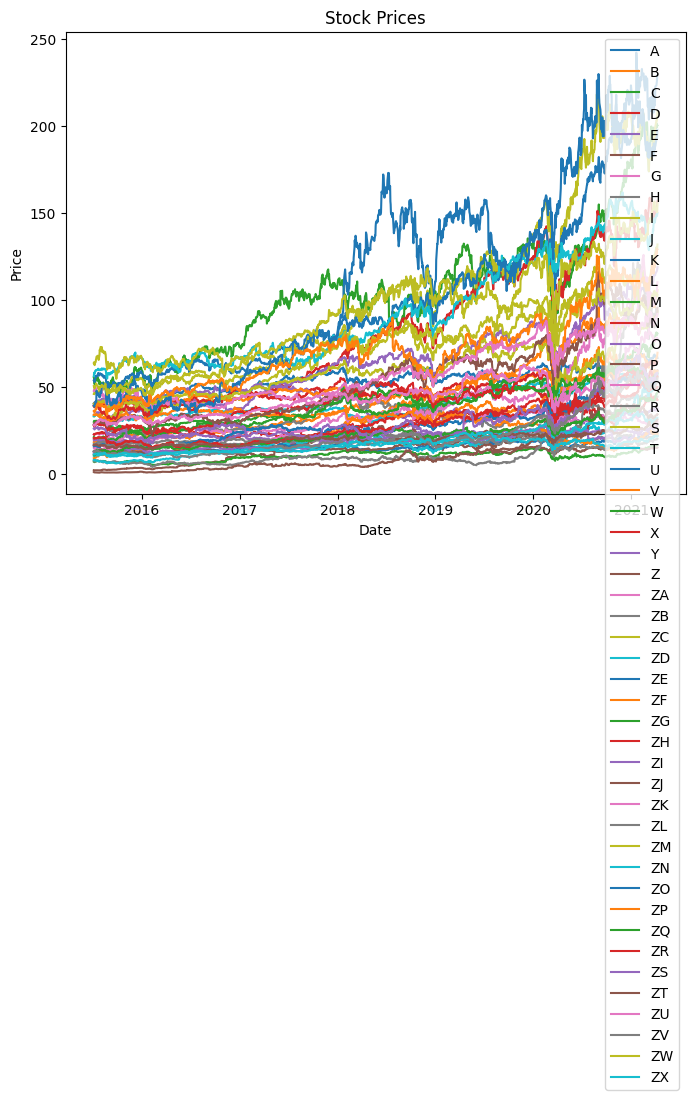

In [2]:
# We can plot all the symbols like below
import matplotlib.pyplot as plt

tickers = sorted(train_df.index.get_level_values('Ticker').unique())

plt.figure(figsize=(8, 6))

for ticker in tickers:
    stock_close_data = train_df.loc[ticker]["Close"]
    plt.plot(stock_close_data.index,stock_close_data.values, label=f'{ticker}')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Prices')
plt.legend()
plt.show()

I will now create a Numpy array of all the stocks and their close prices. This will make it easier to manipulate later.

In [3]:
import numpy as np

tickers = sorted(train_df.index.get_level_values('Ticker').unique())

open_prices = []

for ticker in tickers:
    stock_close_data = train_df.loc[ticker]["Open"]
    open_prices.append(stock_close_data.values)

open_prices = np.stack(open_prices)
print(open_prices.shape)
print(open_prices)

(50, 1452)
[[ 40.30689478  40.68640834  40.59978045 ...  67.46692074  67.65255149
   66.87702022]
 [ 18.13418355  18.2909399   18.33219082 ... 102.22547938 104.27155932
  104.3128071 ]
 [ 56.16811987  55.25645771  53.66827659 ... 198.01159695 201.29934645
  198.00746776]
 ...
 [ 12.8849237   12.98289583  12.83748451 ...  51.9068334   53.19387992
   53.54452067]
 [ 49.33686009  50.47540391  49.10997842 ... 150.23404202 149.78851817
  151.95010825]
 [ 11.13792006  11.2286732   11.17092127 ...  21.45493347  21.42605751
   21.38068212]]


I will now make a trades Numpy array that is initialized to all zeros

In [4]:
trades = np.zeros_like(open_prices)
trades

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Use talib to calculate technical indicators (in this case SMA).

The idea behind the strategy is that we want to have a slower moving average and faster moving average. When the faster SMA crosses above the slower SMA we buy, and when it crosses below the slower SMA we sell. The idea is that we are trying to buy when there is momentum and sell when the momentum slows.

Note here we are not keeping track of how much money we have spent and this could cause us to hit our cash limit or debt limit. We only have $25,000 dollars to spend so you will need to keep track of this as you spend it to buy shares. You will also need to keep track of your short positions value (because if it becomes negative and amounts to more than the value of your long positions and cash your portfolio will be liquidated and your algorithm will fail). 

You could take a look at the [eval_algo.py](eval_algo.py) script to see how we calculate your portfolios value.

In [5]:
# NOTE: that we don't use future price data to make trades in the past!
# This is to prevent "look-ahead bias" which is a common mistake in algorithmic trading, and will result in a score of 0 in the competition
# TODO: have a way to track your positions (short/long positions), your cash balance, adn your portfolio value
# recall the restrictions that you cannot buy a share if you don't have enough cash
# and you can't have your debt exceed the value of your cash and long positions
# "debt" in our case is really just the negative value of our short positions

import talib as ta # in order to run this, you need to install talib see https://github.com/TA-Lib/ta-lib-python

for stock in range(len(open_prices)): 
    fast_sma = ta.SMA(open_prices[stock], timeperiod=5)
    slow_sma = ta.SMA(open_prices[stock], timeperiod=40)

    for day in range(1, len(open_prices[0])-1):
        
        # Buy: fast SMA crosses above slow SMA
        if fast_sma[day] > slow_sma[day] and fast_sma[day-1] <= slow_sma[day-1]:
            # we are trading the next day's open price
            trades[stock][day+1] = 1
        
        # Sell/short: fast SMA crosses below slow SMA
        elif fast_sma[day] < slow_sma[day] and fast_sma[day-1] >= slow_sma[day-1]:
            # we are trading the next day's open price
            trades[stock][day+1] = -1
        # else do nothing
        else:
            trades[stock][day+1] = 0


Now lets calculate the algorithm's returns:

In [6]:
from eval_algo import eval_actions

portfolio_value, sharpe_ratio = eval_actions(trades, open_prices, cash=25000, verbose=True)
print(f"\nPortfolio value: {portfolio_value}")
print(f"Sharpe ratio: {sharpe_ratio}")

final portfolio value: 26039.515206844866
cash: 22815.271530414553
positions: [1.0, 1.0, 1.0, 1.0, 1.0, -19.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
short position info: defaultdict(<class 'list'>, {5: []})
short value: 0

Portfolio value: [25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000.693440125644, 24998.4027438011, 24996.14112722376, 24996.368835830574, 24996.368835830574, 24996.368835830574, 24996.12133105937, 24998.282910127607, 24998.19628376258, 24999.42826030608, 24998.88291266222, 24997.74106846432, 24999.561020497247, 24996.32958055194, 24996.936255

We see we made a small profit!

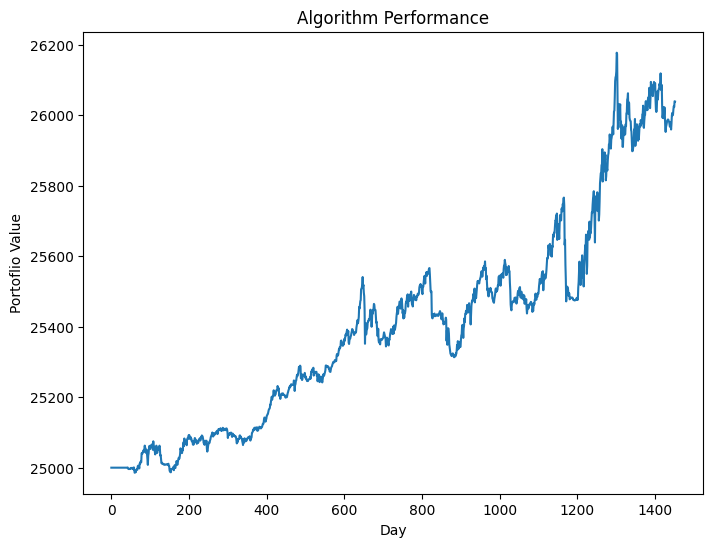

In [7]:
plt.figure(figsize=(8, 6))

plt.plot(portfolio_value, label=f'{ticker}')

plt.xlabel('Day')
plt.ylabel('Portoflio Value')
plt.title('Algorithm Performance')
plt.show()